# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download(['punkt', 'wordnet'])

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#imblearn
from imblearn.over_sampling import RandomOverSampler

from sklearn.base import BaseEstimator, TransformerMixin
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from imblearn.under_sampling import RandomUnderSampler

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mansi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mansi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# load data from database
engine = create_engine('sqlite:///messages.db')
df = pd.read_sql_table("messages", con=engine)

In [4]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = df["message"]
y = df.drop(['message', 'genre', 'id', 'original'], axis = 1)

### 2. Write a tokenization function to process your text data

In [6]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

In [7]:
def tokenize(text):
    '''
    Receives text related data and processes it
    Args: text related data (columns)
    Returns: tokenized text
    '''
    # get list of all urls using regex
    detected_urls = re.findall(url_regex, text) 
    
    # replace each url in text string with placeholder
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    # tokenize text
    tokens = word_tokenize(text)
    
    # initiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # iterate through each token
    clean_tokens = []
    for tok in tokens:
        
        # lemmatize, normalize case, and remove leading/trailing white space
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline

In [8]:
def multi_tester(X, y):
    '''
    Function to create list of fitted models
    Args: training data X and y
    returns: list of the selected fitted models
    '''
    pipe_1 = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42)))
    ])
    
    pipe_2 = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(ExtraTreesClassifier(random_state=42)))
    ])
    
    pipe_3 = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(GradientBoostingClassifier(random_state=42)))
    ])
    
    pipe_4 = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(AdaBoostClassifier(random_state=42)))
    ])
    
    pipe_5 = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(SVC(random_state=42)))
    ])
    
    pips = [pipe_1, pipe_2, pipe_3, pipe_4, pipe_5]
    pip_names = ['RandomForestClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 
                 'AdaBoostClassifier', 'SVC']
    
    model_fits = []
    for i in range(len(pips)):
        print('Model: ', pip_names[i])
        print(pips[i].get_params())
        mdl = pips[i].fit(X, y)
        model_fits.append(mdl)
        
    return model_fits

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.33)

In [10]:
fitted_mdls = multi_tester(X_train, y_train)

Model:  RandomForestClassifier
{'memory': None, 'steps': [('vect', CountVectorizer(tokenizer=<function tokenize at 0x000001E50212F280>)), ('tfidf', TfidfTransformer()), ('clf', MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42)))], 'verbose': False, 'vect': CountVectorizer(tokenizer=<function tokenize at 0x000001E50212F280>), 'tfidf': TfidfTransformer(), 'clf': MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42)), 'vect__analyzer': 'word', 'vect__binary': False, 'vect__decode_error': 'strict', 'vect__dtype': <class 'numpy.int64'>, 'vect__encoding': 'utf-8', 'vect__input': 'content', 'vect__lowercase': True, 'vect__max_df': 1.0, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 1), 'vect__preprocessor': None, 'vect__stop_words': None, 'vect__strip_accents': None, 'vect__token_pattern': '(?u)\\b\\w\\w+\\b', 'vect__tokenizer': <function tokenize at 0x000001E50212F280>, 'vect__vocabulary': None, 'tfidf__norm': 'l2', 'tfidf__smo

### 5. Test your models
Report the f1 score, precision and recall for each output category of the dataset.

In [11]:
target_names = y_train.columns.tolist()

In [12]:
print(y_test.shape)
print(X_test.shape)
print(X_train.shape)

(8652, 35)
(8652,)
(17564,)


Confusion Matrix for each Classifier

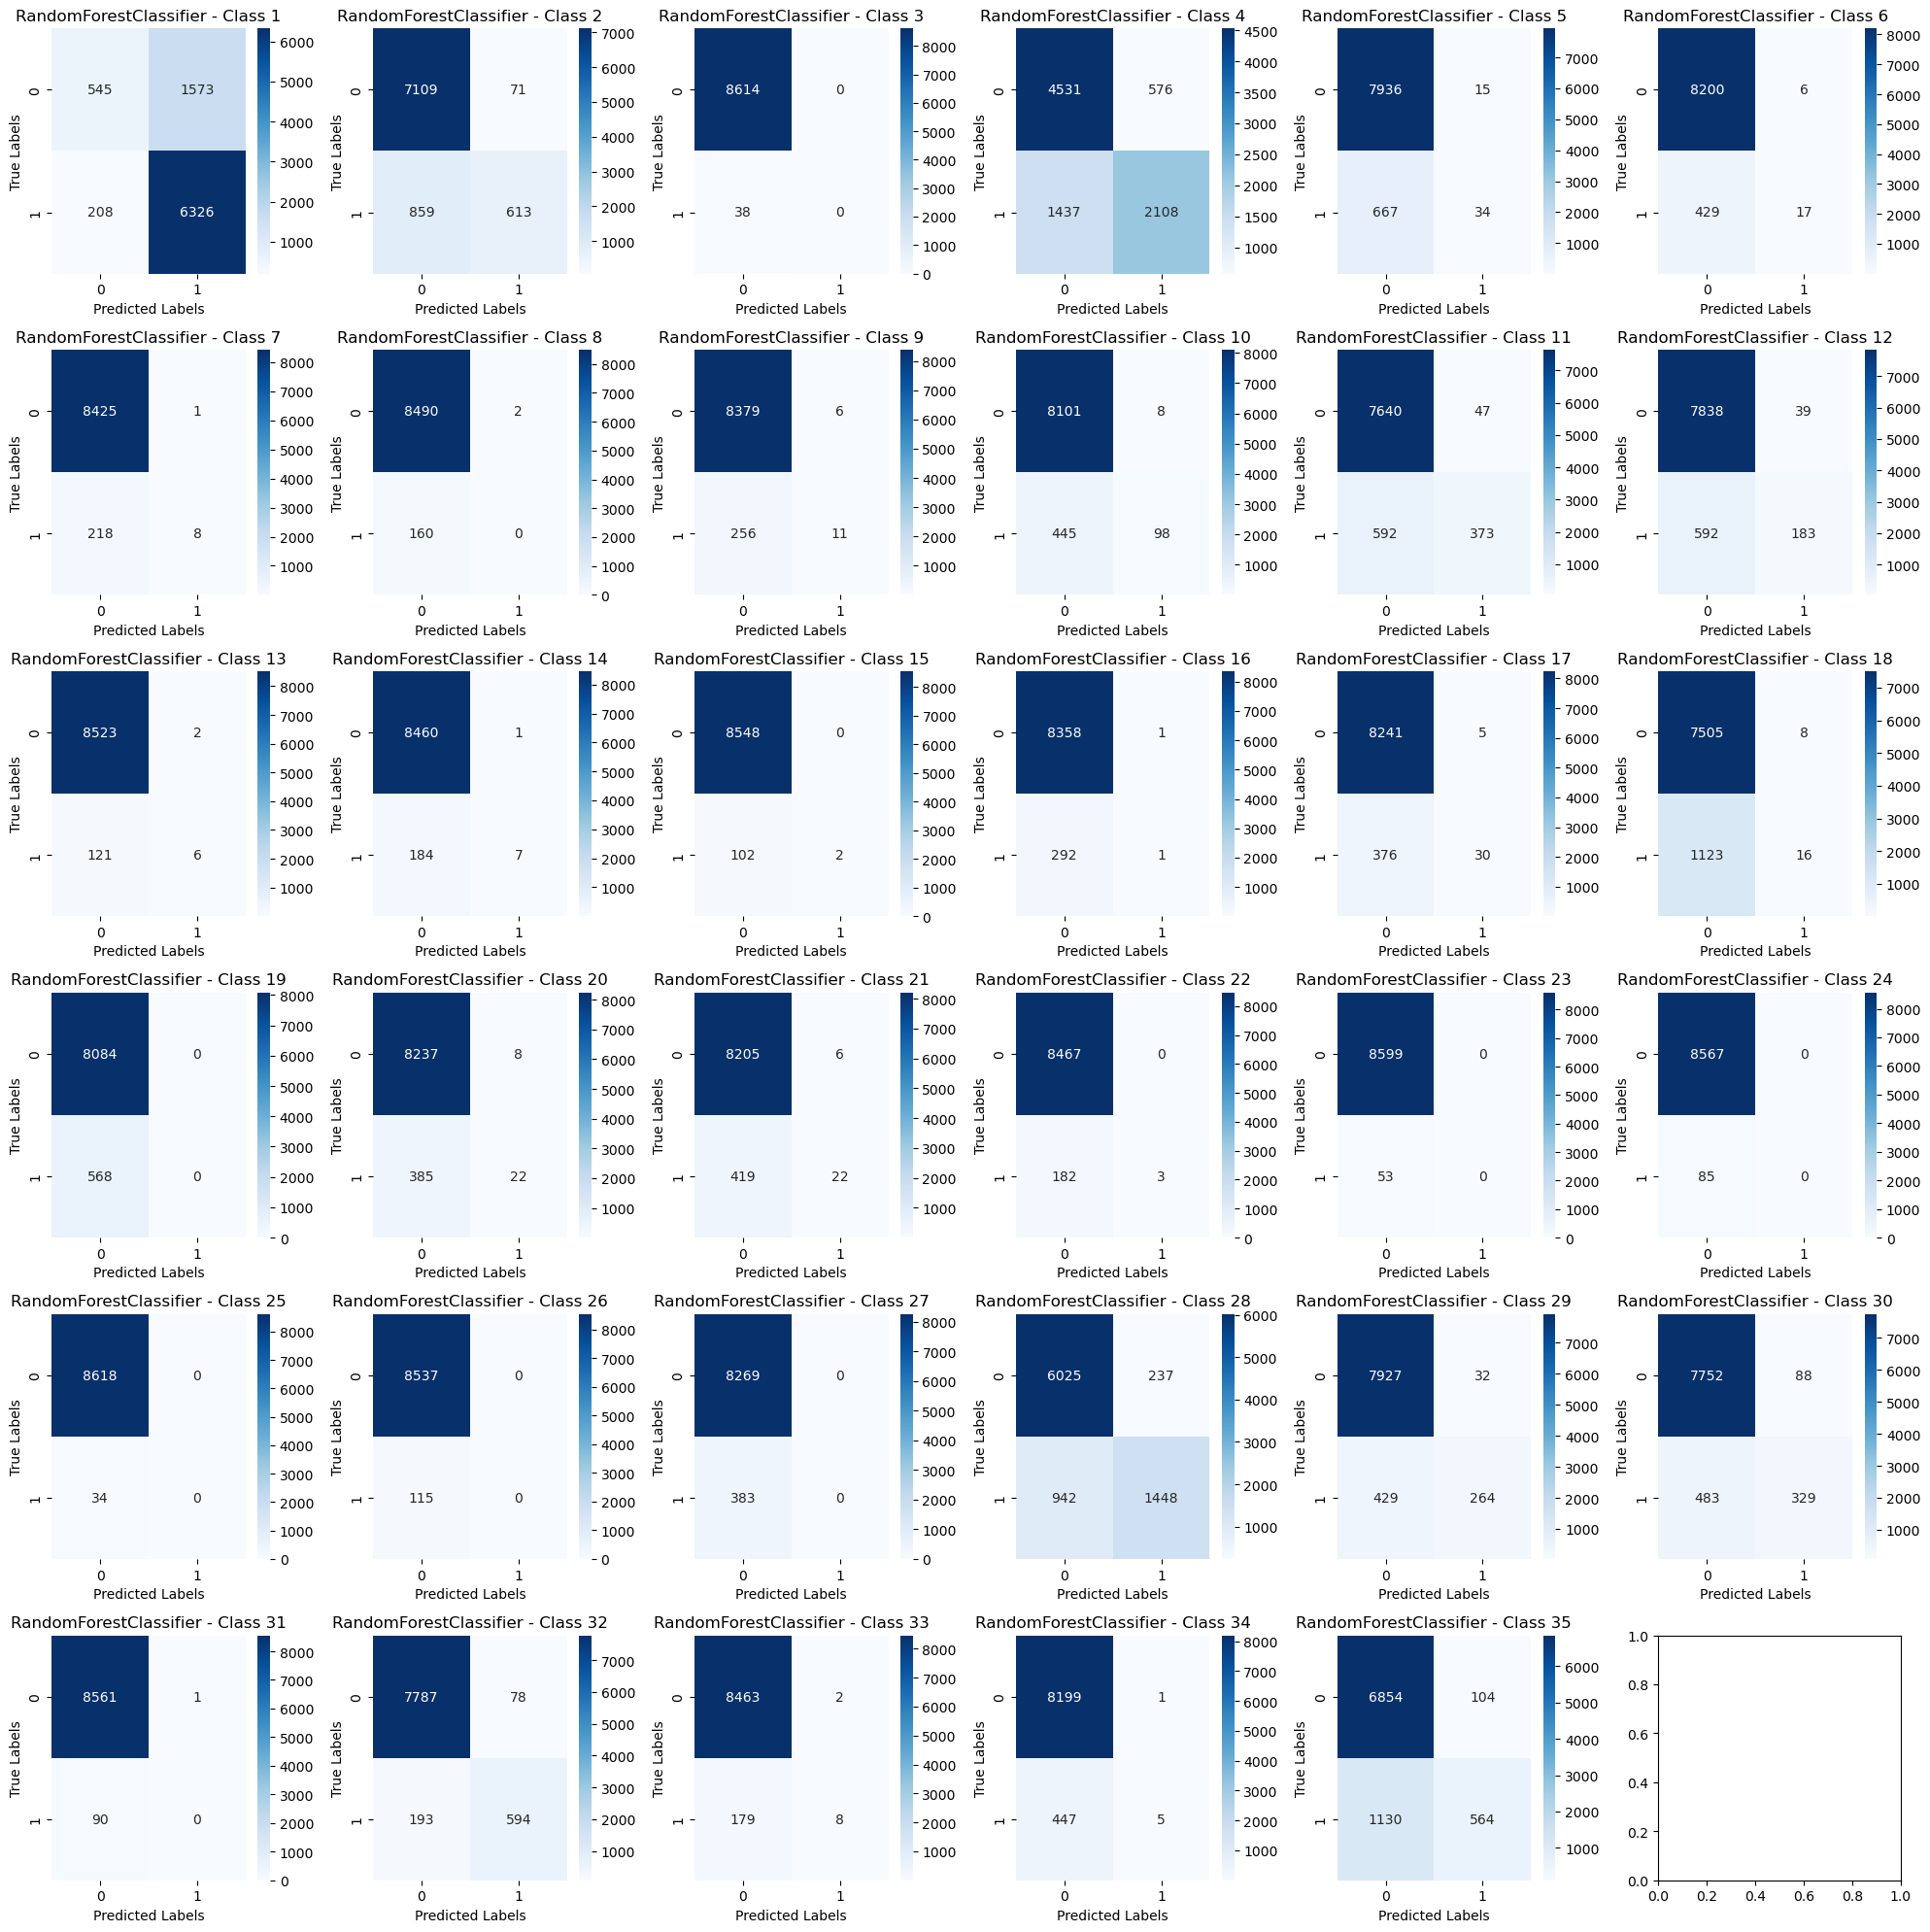

In [14]:
# Calculate and plot the confusion matrix for model 1
model = fitted_mdls[0]
y_pred = model.predict(X_test)
mcm = multilabel_confusion_matrix(y_test, y_pred)
title = type(model.named_steps['clf'].estimator).__name__

# Create subplots for each class
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(20, 20))

# Loop over all classes and plot the corresponding confusion matrix
for i in range(len(mcm)):
    row = i // 6
    col = i % 6
    sns.heatmap(mcm[i], annot=True, cmap='Blues', fmt='g', ax=axs[row, col])
    axs[row, col].set_xlabel('Predicted Labels')
    axs[row, col].set_ylabel('True Labels')
    axs[row, col].set_title(title + ' - Class ' + str(i+1))
    
plt.tight_layout()
plt.show()

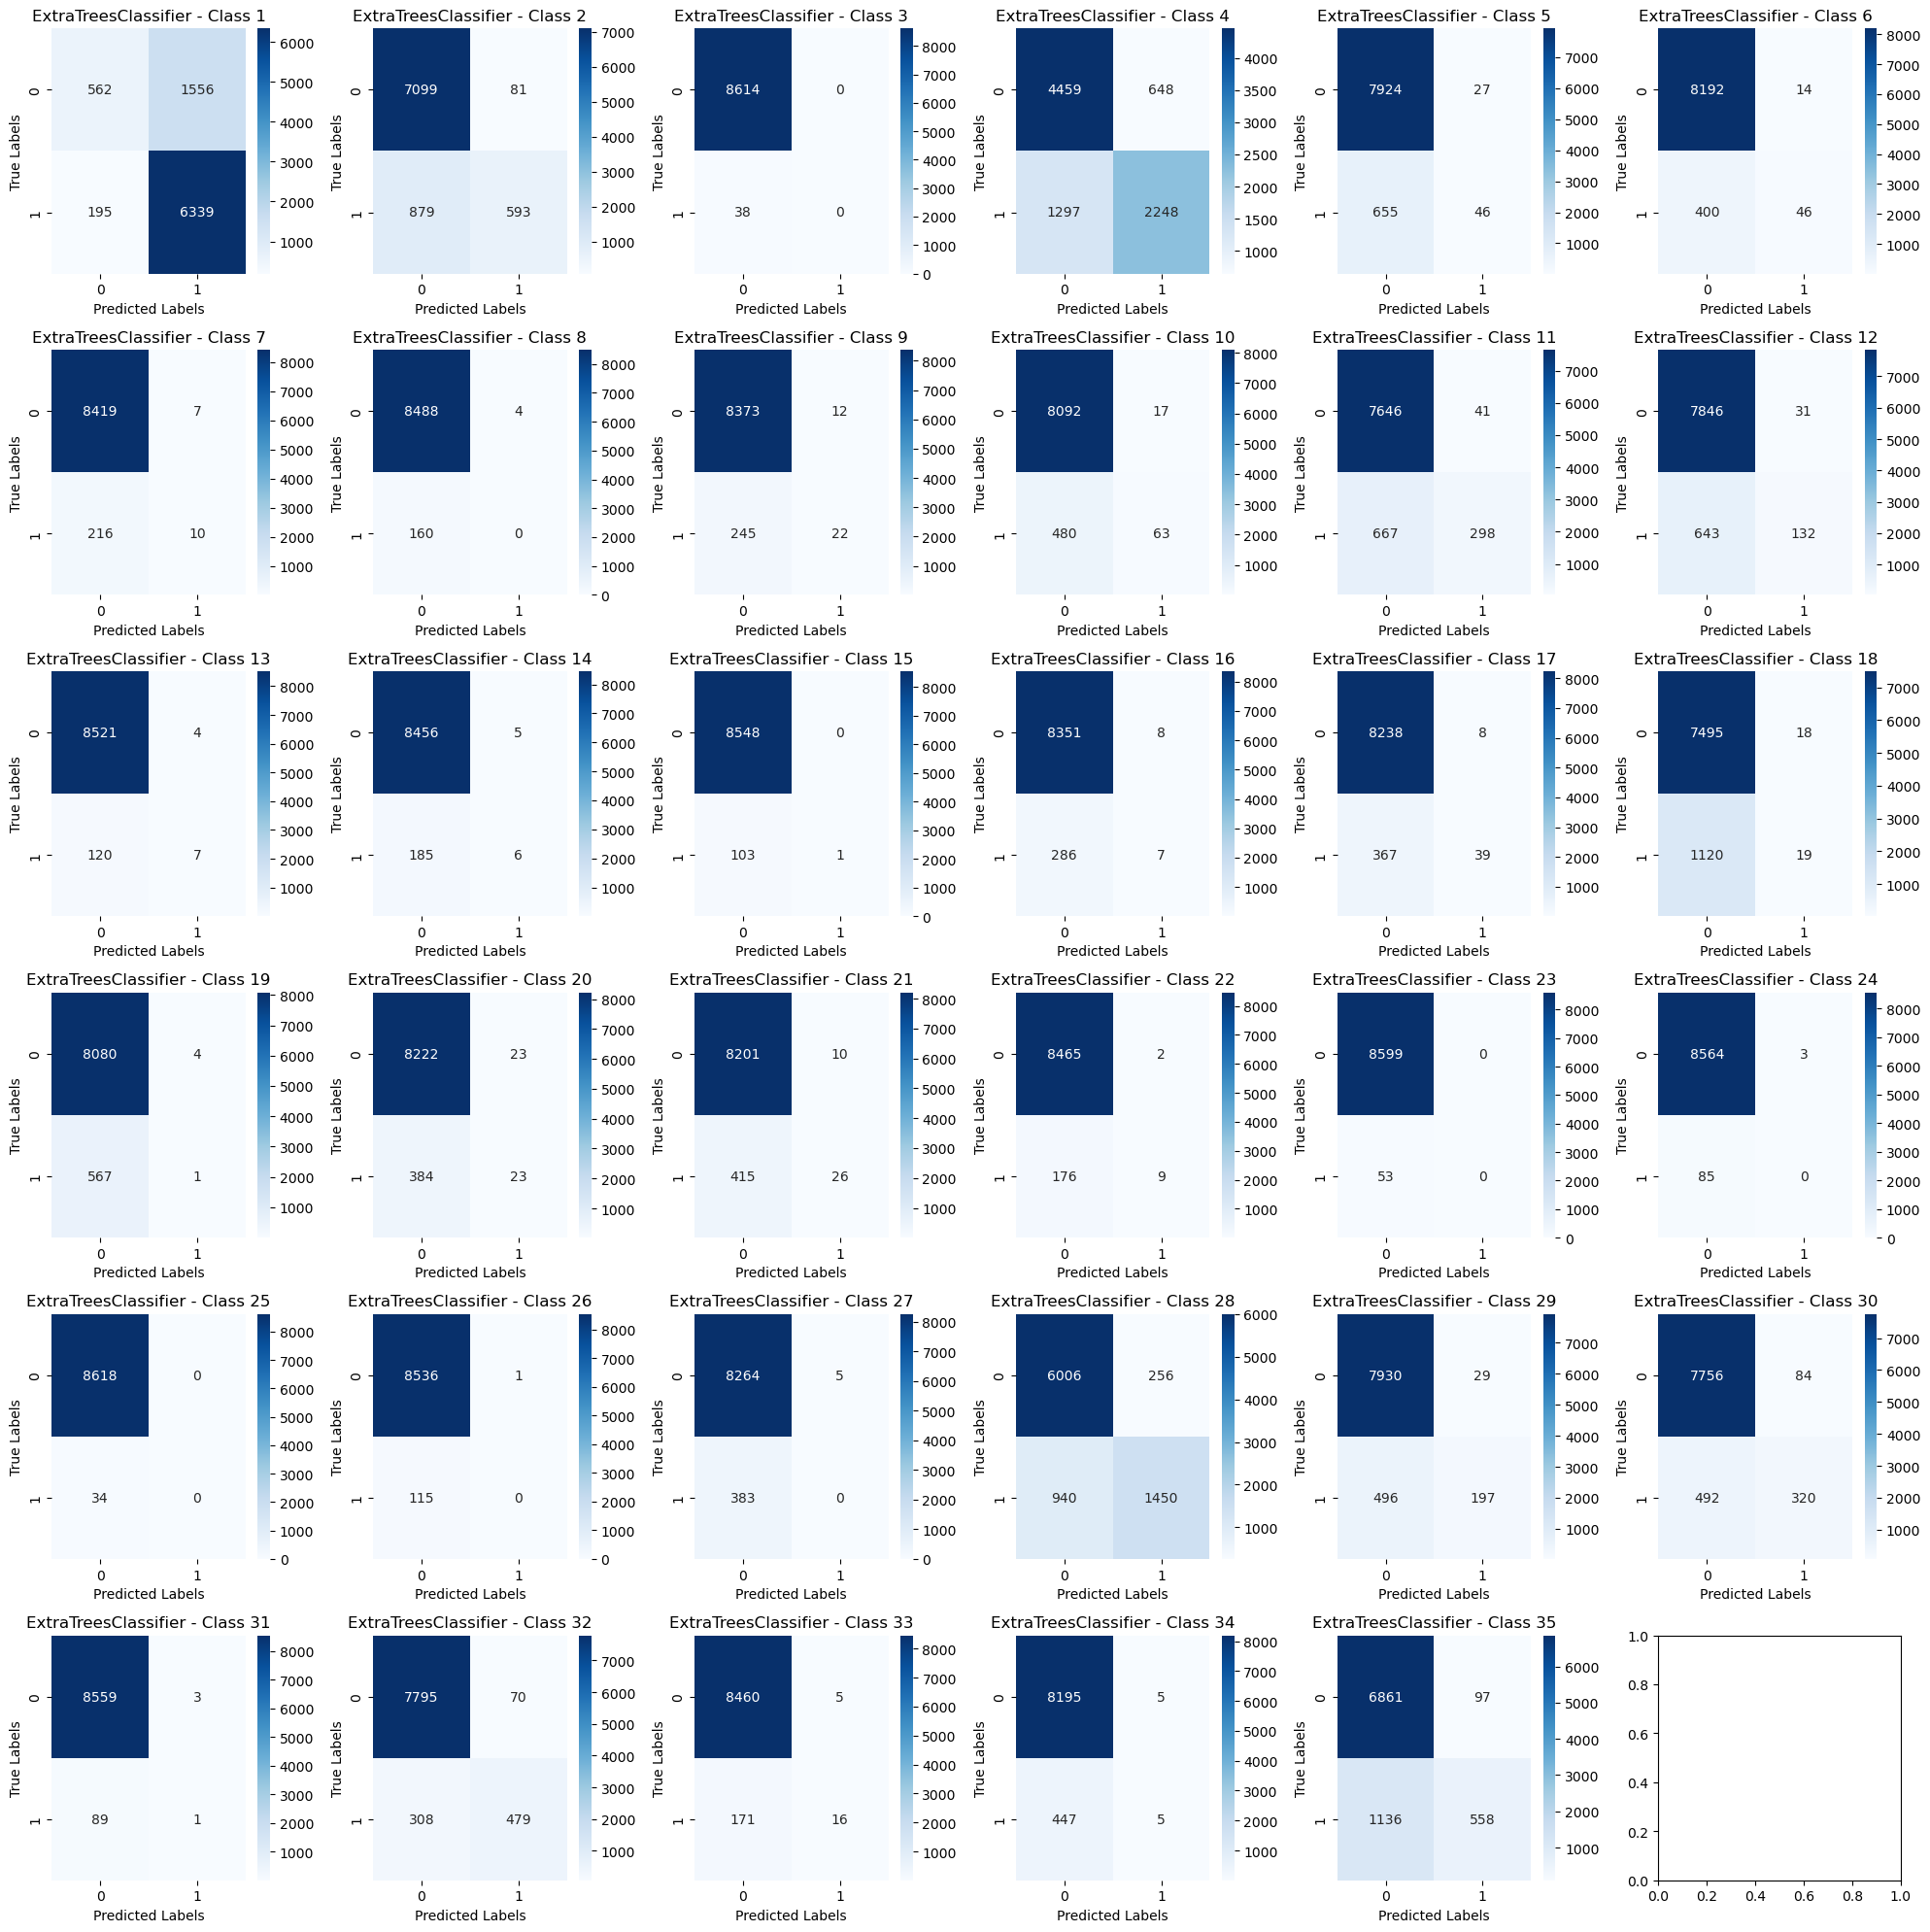

In [15]:
# Calculate and plot the confusion matrix for model 2
model = fitted_mdls[1]
y_pred = model.predict(X_test)
mcm = multilabel_confusion_matrix(y_test, y_pred)
title = type(model.named_steps['clf'].estimator).__name__

# Create subplots for each class
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(20, 20))

# Loop over all classes and plot the corresponding confusion matrix
for i in range(len(mcm)):
    row = i // 6
    col = i % 6
    sns.heatmap(mcm[i], annot=True, cmap='Blues', fmt='g', ax=axs[row, col])
    axs[row, col].set_xlabel('Predicted Labels')
    axs[row, col].set_ylabel('True Labels')
    axs[row, col].set_title(title + ' - Class ' + str(i+1))
    
plt.tight_layout()
plt.show()

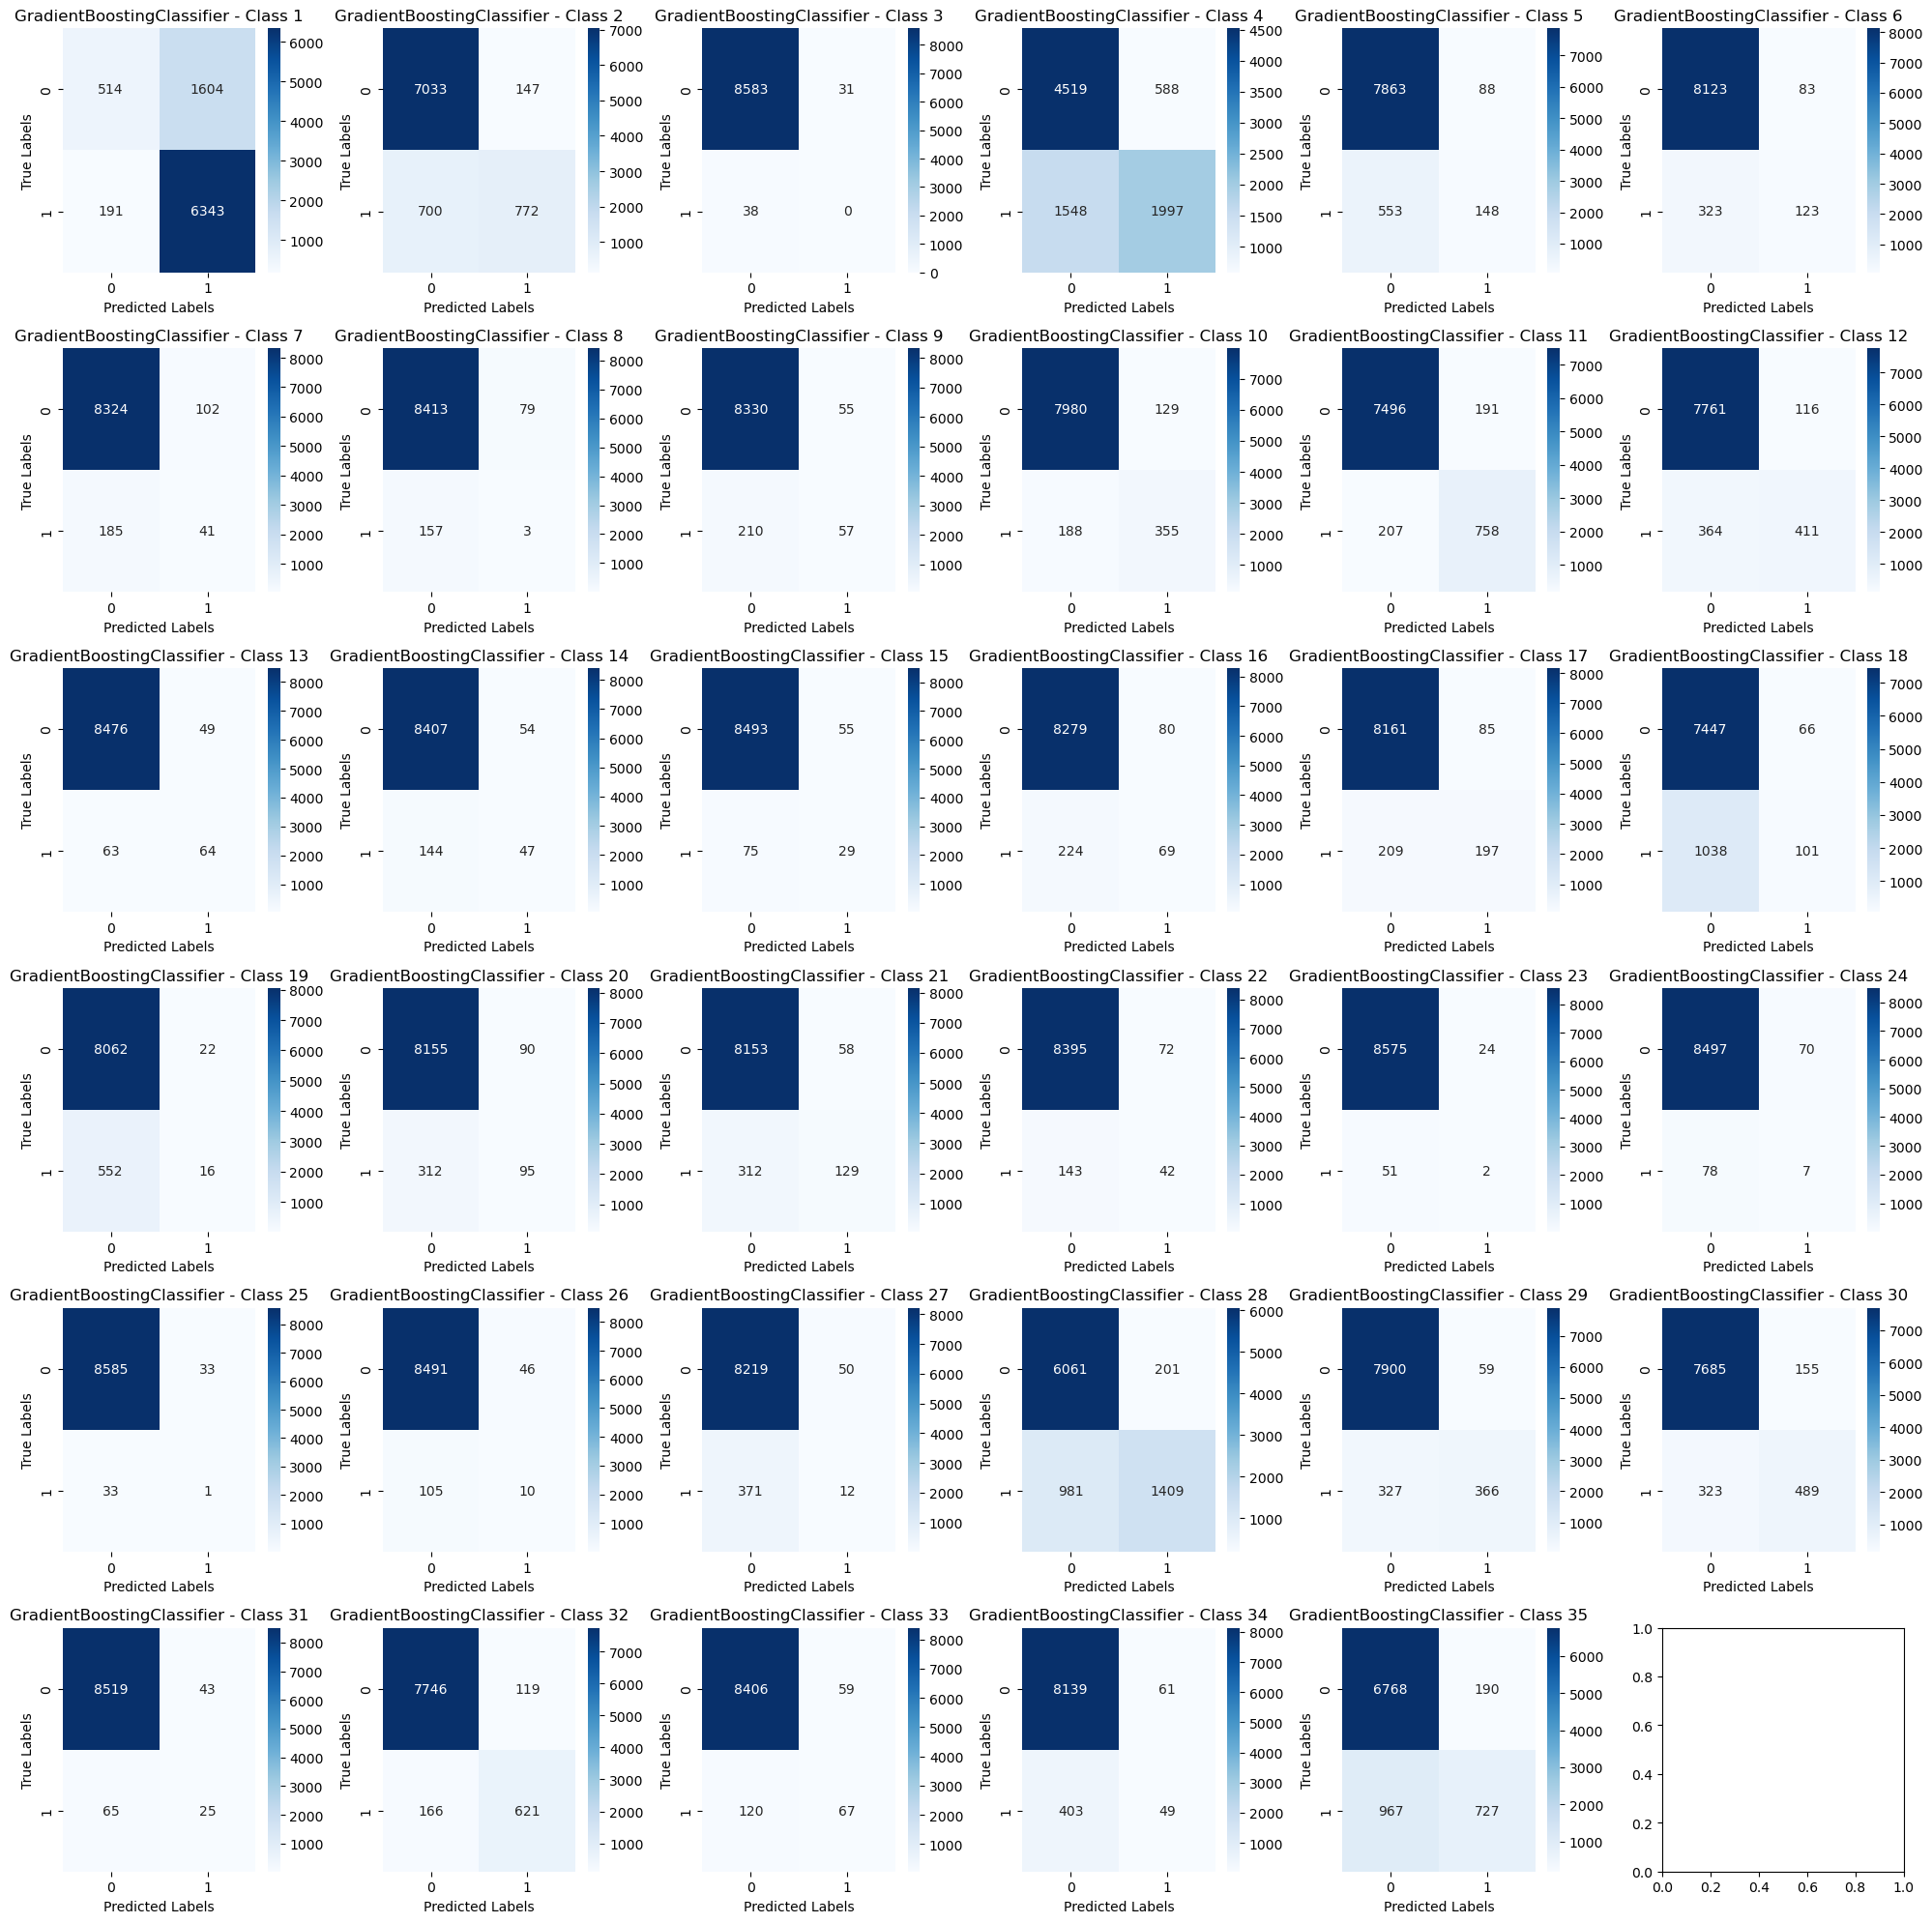

In [16]:
# Calculate and plot the confusion matrix for model 3
model = fitted_mdls[2]
y_pred = model.predict(X_test)
mcm = multilabel_confusion_matrix(y_test, y_pred)
title = type(model.named_steps['clf'].estimator).__name__

# Create subplots for each class
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(20, 20))

# Loop over all classes and plot the corresponding confusion matrix
for i in range(len(mcm)):
    row = i // 6
    col = i % 6
    sns.heatmap(mcm[i], annot=True, cmap='Blues', fmt='g', ax=axs[row, col])
    axs[row, col].set_xlabel('Predicted Labels')
    axs[row, col].set_ylabel('True Labels')
    axs[row, col].set_title(title + ' - Class ' + str(i+1))
    
plt.tight_layout()
plt.show()

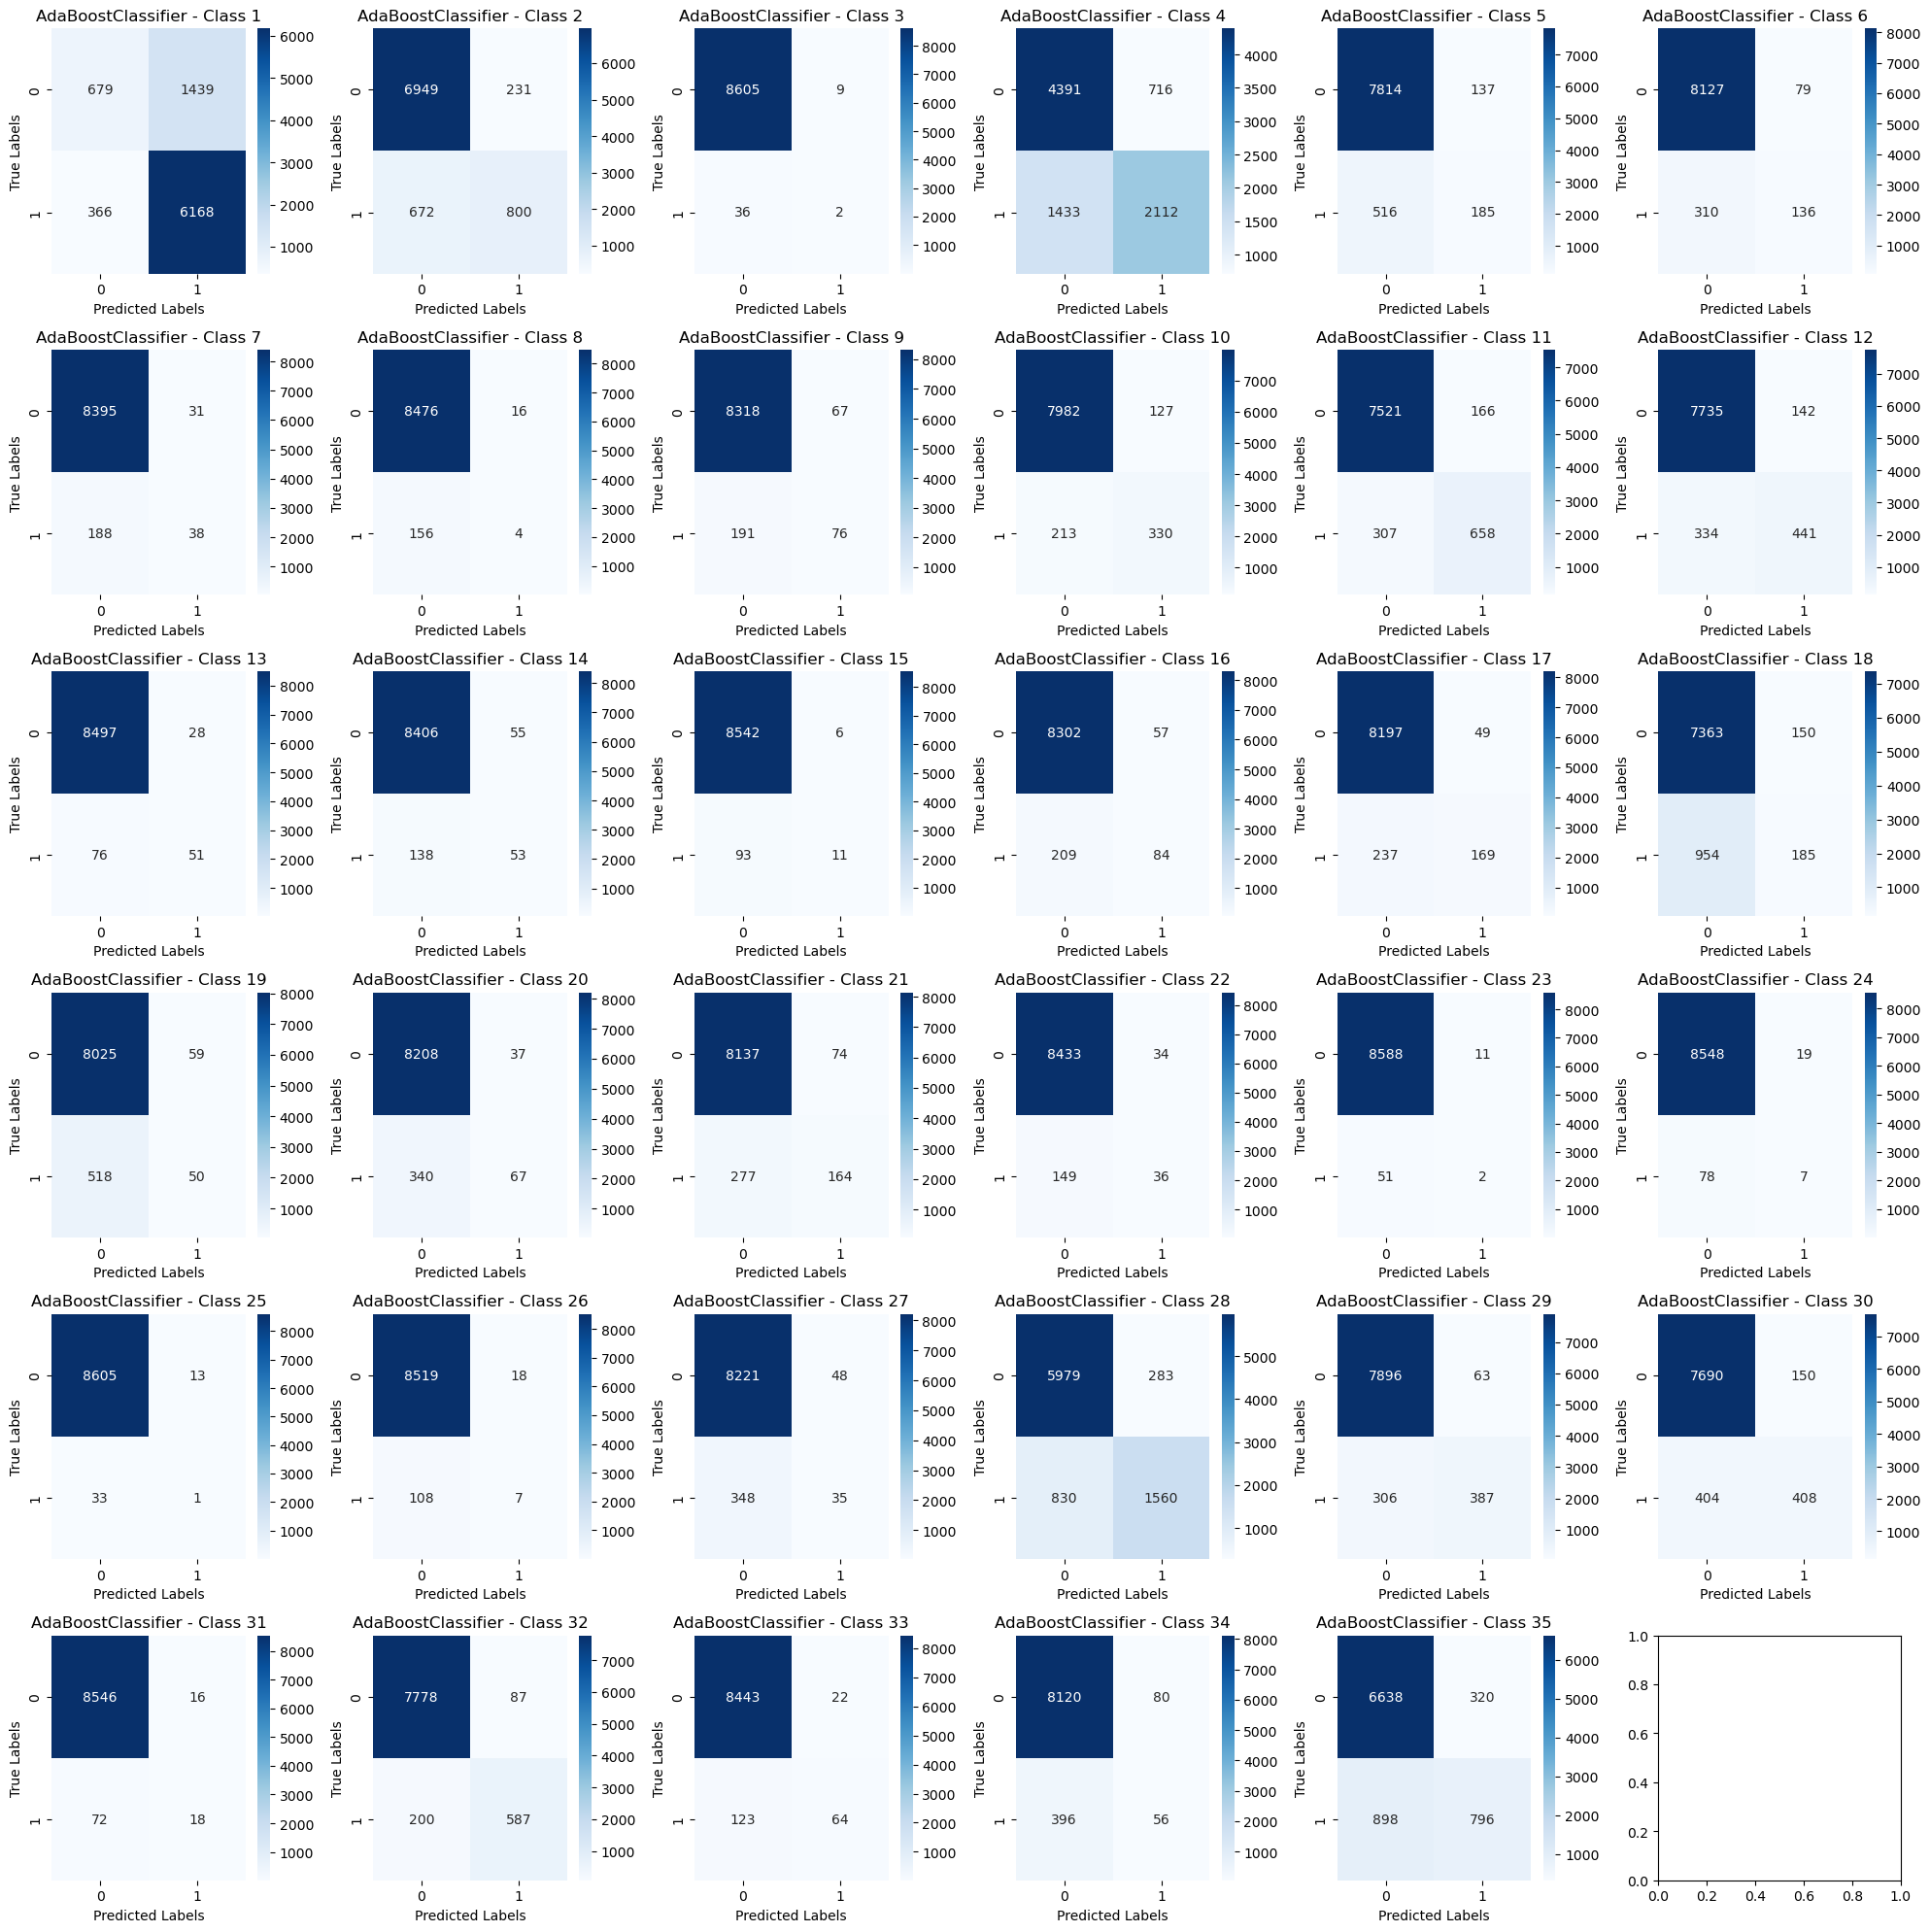

In [17]:
# Calculate and plot the confusion matrix for model 4
model = fitted_mdls[3]
y_pred = model.predict(X_test)
mcm = multilabel_confusion_matrix(y_test, y_pred)
title = type(model.named_steps['clf'].estimator).__name__

# Create subplots for each class
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(20, 20))

# Loop over all classes and plot the corresponding confusion matrix
for i in range(len(mcm)):
    row = i // 6
    col = i % 6
    sns.heatmap(mcm[i], annot=True, cmap='Blues', fmt='g', ax=axs[row, col])
    axs[row, col].set_xlabel('Predicted Labels')
    axs[row, col].set_ylabel('True Labels')
    axs[row, col].set_title(title + ' - Class ' + str(i+1))
    
plt.tight_layout()
plt.show()

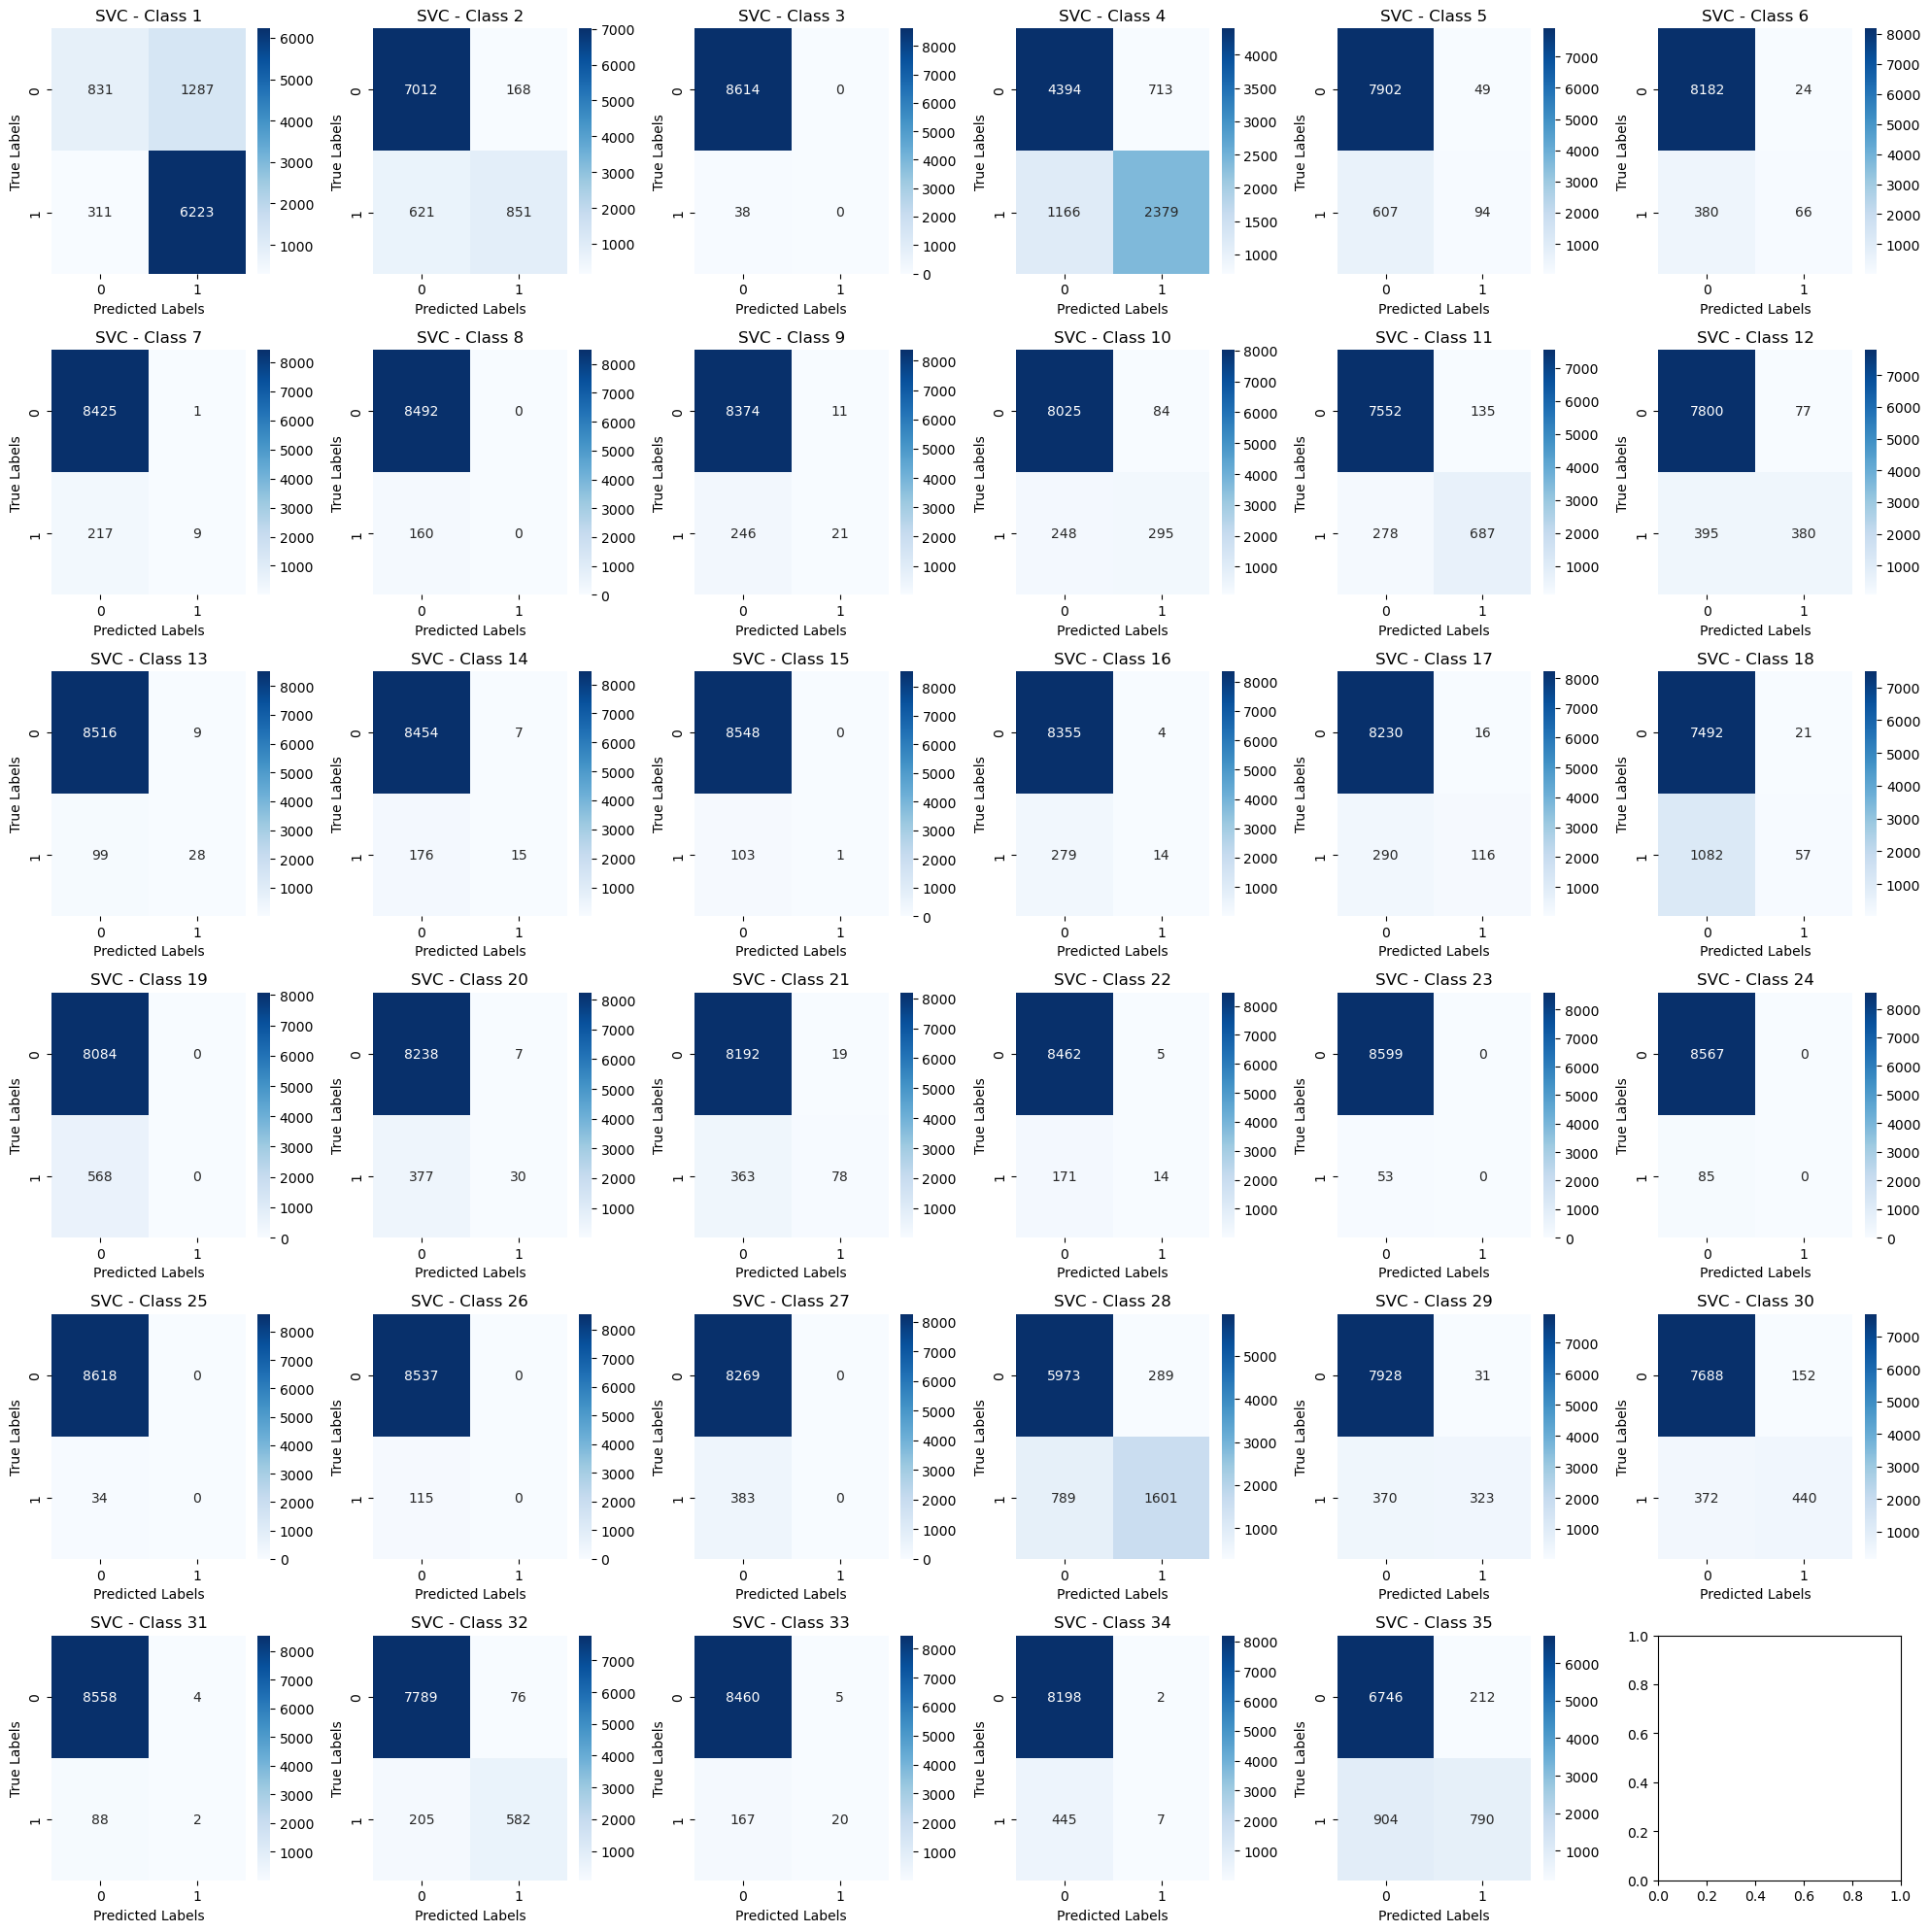

In [18]:
# Calculate and plot the confusion matrix for model 5
model = fitted_mdls[4]
y_pred = model.predict(X_test)
mcm = multilabel_confusion_matrix(y_test, y_pred)
title = type(model.named_steps['clf'].estimator).__name__

# Create subplots for each class
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(20, 20))

# Loop over all classes and plot the corresponding confusion matrix
for i in range(len(mcm)):
    row = i // 6
    col = i % 6
    sns.heatmap(mcm[i], annot=True, cmap='Blues', fmt='g', ax=axs[row, col])
    axs[row, col].set_xlabel('Predicted Labels')
    axs[row, col].set_ylabel('True Labels')
    axs[row, col].set_title(title + ' - Class ' + str(i+1))
    
plt.tight_layout()
plt.show()

In [19]:
def perf_report(model, X_test, y_test):
    '''
    Function to return model classification reports
    Input: Model list, and test data 
    Output: Generates the Classification report
    '''
    classifier_names = ['RandomForestClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 
             'AdaBoostClassifier', 'SVC']
    
    for i in range(len(model)):
        print('==========================Model===========================')
        print('==========================', classifier_names[i], '==========================')
        y_pred = model[i].predict(X_test)
        print(classification_report(y_test, y_pred, target_names = target_names))

In [21]:
perf_report(fitted_mdls, X_test, y_test)

==========================Model===========================
========================== RandomForestClassifier ==========================


c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

               related       0.80      0.97      0.88      6534
               request       0.90      0.42      0.57      1472
                 offer       0.00      0.00      0.00        38
           aid_related       0.79      0.59      0.68      3545
          medical_help       0.69      0.05      0.09       701
      medical_products       0.74      0.04      0.07       446
     search_and_rescue       0.89      0.04      0.07       226
              security       0.00      0.00      0.00       160
              military       0.65      0.04      0.08       267
                 water       0.92      0.18      0.30       543
                  food       0.89      0.39      0.54       965
               shelter       0.82      0.24      0.37       775
              clothing       0.75      0.05      0.09       127
                 money       0.88      0.04      0.07       191
        missing_people       1.00      

c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

               related       0.80      0.97      0.88      6534
               request       0.88      0.40      0.55      1472
                 offer       0.00      0.00      0.00        38
           aid_related       0.78      0.63      0.70      3545
          medical_help       0.63      0.07      0.12       701
      medical_products       0.77      0.10      0.18       446
     search_and_rescue       0.59      0.04      0.08       226
              security       0.00      0.00      0.00       160
              military       0.65      0.08      0.15       267
                 water       0.79      0.12      0.20       543
                  food       0.88      0.31      0.46       965
               shelter       0.81      0.17      0.28       775
              clothing       0.64      0.06      0.10       127
                 money       0.55      0.03      0.06       191
        missing_people       1.00      

c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

               related       0.80      0.97      0.88      6534
               request       0.84      0.52      0.65      1472
                 offer       0.00      0.00      0.00        38
           aid_related       0.77      0.56      0.65      3545
          medical_help       0.63      0.21      0.32       701
      medical_products       0.60      0.28      0.38       446
     search_and_rescue       0.29      0.18      0.22       226
              security       0.04      0.02      0.02       160
              military       0.51      0.21      0.30       267
                 water       0.73      0.65      0.69       543
                  food       0.80      0.79      0.79       965
               shelter       0.78      0.53      0.63       775
              clothing       0.57      0.50      0.53       127
                 money       0.47      0.25      0.32       191
        missing_people       0.35      

c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

               related       0.81      0.94      0.87      6534
               request       0.78      0.54      0.64      1472
                 offer       0.18      0.05      0.08        38
           aid_related       0.75      0.60      0.66      3545
          medical_help       0.57      0.26      0.36       701
      medical_products       0.63      0.30      0.41       446
     search_and_rescue       0.55      0.17      0.26       226
              security       0.20      0.03      0.04       160
              military       0.53      0.28      0.37       267
                 water       0.72      0.61      0.66       543
                  food       0.80      0.68      0.74       965
               shelter       0.76      0.57      0.65       775
              clothing       0.65      0.40      0.50       127
                 money       0.49      0.28      0.35       191
        missing_people       0.65      

c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-shops has very little label diversity so it became an edge case, I will drop it for the optimization

______________________________ RandomForestClassifier ______________________________


                           precision    recall  f1-score   support
                           
                           
             micro avg       0.80      0.44      0.57     27308
             
             
             macro avg       0.58      0.16      0.21     27308
             
             
          weighted avg       0.74      0.44      0.50     27308
          
          
           samples avg       0.65      0.42      0.46     27308
           

______________________________ ExtraTreesClassifier ______________________________


             micro avg       0.79      0.44      0.56     27308
             
             
             macro avg       0.53      0.15      0.21     27308
             
             
          weighted avg       0.71      0.44      0.49     27308
          
          
           samples avg       0.66      0.42      0.46     27308

______________________________ GradientBoostingClassifier ______________________________


             micro avg       0.76      0.57      0.65     27308
             
             
             macro avg       0.51      0.32      0.38     27308
             
             
          weighted avg       0.72      0.57      0.61     27308
          
          
           samples avg       0.65      0.50      0.52     27308
           
           
______________________________ AdaBoostClassifier ______________________________


             micro avg       0.77      0.58      0.66     27308
             
             
             macro avg       0.58      0.33      0.40     27308
             
             
          weighted avg       0.73      0.58      0.62     27308
          
          
           samples avg       0.63      0.50      0.51     27308
           
______________________________ SVC ______________________________


             micro avg       0.76      0.24      0.36     27308
             
             
             macro avg       0.02      0.03      0.02     27308
             
             
          weighted avg       0.18      0.24      0.21     27308
          
          
           samples avg       0.76      0.32      0.40     27308


### 6. Improve models based on poor target performance elimination
Testing models after dropping poor predictors

In [22]:
# dropping the targets that had the word performances based on the classification report
targs_drop = ['offer', 'security', 'infrastructure_related', 'tools', 
              'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'fire', 'other_weather']
y_min = y.copy()
y_min.drop(targs_drop, axis = 1, inplace = True)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y_min, random_state = 42, test_size = 0.33)

In [24]:
fitted_mdls_min = multi_tester(X_train, y_train)

Model:  RandomForestClassifier
{'memory': None, 'steps': [('vect', CountVectorizer(tokenizer=<function tokenize at 0x000001E50212F280>)), ('tfidf', TfidfTransformer()), ('clf', MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42)))], 'verbose': False, 'vect': CountVectorizer(tokenizer=<function tokenize at 0x000001E50212F280>), 'tfidf': TfidfTransformer(), 'clf': MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42)), 'vect__analyzer': 'word', 'vect__binary': False, 'vect__decode_error': 'strict', 'vect__dtype': <class 'numpy.int64'>, 'vect__encoding': 'utf-8', 'vect__input': 'content', 'vect__lowercase': True, 'vect__max_df': 1.0, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 1), 'vect__preprocessor': None, 'vect__stop_words': None, 'vect__strip_accents': None, 'vect__token_pattern': '(?u)\\b\\w\\w+\\b', 'vect__tokenizer': <function tokenize at 0x000001E50212F280>, 'vect__vocabulary': None, 'tfidf__norm': 'l2', 'tfidf__smo

In [25]:
target_names = y_train.columns.tolist()

In [26]:
perf_report(fitted_mdls_min, X_test, y_test)

==========================Model===========================
========================== RandomForestClassifier ==========================


c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          related       0.80      0.97      0.88      6534
          request       0.90      0.42      0.57      1472
      aid_related       0.79      0.59      0.68      3545
     medical_help       0.69      0.05      0.09       701
 medical_products       0.74      0.04      0.07       446
search_and_rescue       0.89      0.04      0.07       226
         military       0.65      0.04      0.08       267
            water       0.92      0.18      0.30       543
             food       0.89      0.39      0.54       965
          shelter       0.82      0.24      0.37       775
         clothing       0.75      0.05      0.09       127
            money       0.88      0.04      0.07       191
   missing_people       1.00      0.02      0.04       104
         refugees       0.50      0.00      0.01       293
            death       0.86      0.07      0.14       406
        other_aid       0.67      0.01      0.03      1

c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          related       0.80      0.97      0.88      6534
          request       0.88      0.40      0.55      1472
      aid_related       0.78      0.63      0.70      3545
     medical_help       0.63      0.07      0.12       701
 medical_products       0.77      0.10      0.18       446
search_and_rescue       0.59      0.04      0.08       226
         military       0.65      0.08      0.15       267
            water       0.79      0.12      0.20       543
             food       0.88      0.31      0.46       965
          shelter       0.81      0.17      0.28       775
         clothing       0.64      0.06      0.10       127
            money       0.55      0.03      0.06       191
   missing_people       1.00      0.01      0.02       104
         refugees       0.47      0.02      0.05       293
            death       0.83      0.10      0.17       406
        other_aid       0.51      0.02      0.03      1

c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          related       0.80      0.97      0.88      6534
          request       0.84      0.52      0.65      1472
      aid_related       0.77      0.56      0.65      3545
     medical_help       0.63      0.21      0.32       701
 medical_products       0.60      0.28      0.38       446
search_and_rescue       0.29      0.18      0.22       226
         military       0.51      0.21      0.30       267
            water       0.73      0.65      0.69       543
             food       0.80      0.79      0.79       965
          shelter       0.78      0.53      0.63       775
         clothing       0.57      0.50      0.53       127
            money       0.47      0.25      0.32       191
   missing_people       0.35      0.28      0.31       104
         refugees       0.46      0.24      0.31       293
            death       0.70      0.49      0.57       406
        other_aid       0.60      0.09      0.15      1

c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          related       0.81      0.94      0.87      6534
          request       0.78      0.54      0.64      1472
      aid_related       0.75      0.60      0.66      3545
     medical_help       0.57      0.26      0.36       701
 medical_products       0.63      0.30      0.41       446
search_and_rescue       0.55      0.17      0.26       226
         military       0.53      0.28      0.37       267
            water       0.72      0.61      0.66       543
             food       0.80      0.68      0.74       965
          shelter       0.76      0.57      0.65       775
         clothing       0.65      0.40      0.50       127
            money       0.49      0.28      0.35       191
   missing_people       0.65      0.11      0.18       104
         refugees       0.60      0.29      0.39       293
            death       0.78      0.42      0.54       406
        other_aid       0.55      0.16      0.25      1

c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



______________________________ RandomForestClassifier ______________________________

                           precision    recall  f1-score   support 
                           
              micro avg       0.80      0.48      0.60     25330
              
              macro avg       0.72      0.22      0.30     25330
              
           weighted avg       0.78      0.48      0.53     25330
           
            samples avg       0.66      0.44      0.48     25330

______________________________ ExtraTreesClassifier ______________________________

        micro avg       0.79      0.46      0.59     25330
        
        macro avg       0.68      0.20      0.27     25330
        
     weighted avg       0.75      0.46      0.52     25330
     
      samples avg       0.65      0.43      0.47     25330    

______________________________ GradientBoostingClassifier ______________________________

        micro avg       0.78      0.61      0.68     25330
        
        macro avg       0.65      0.43      0.50     25330
        
     weighted avg       0.76      0.61      0.65     25330
     
      samples avg       0.66      0.52      0.54     25330
           
           
______________________________ AdaBoostClassifier ______________________________

        micro avg       0.77      0.61      0.69     25330
        
        macro avg       0.69      0.42      0.51     25330
        
     weighted avg       0.75      0.61      0.66     25330
     
      samples avg       0.64      0.51      0.53     25330
           
______________________________ SVC ______________________________

        micro avg       0.76      0.26      0.38     25330
        
        macro avg       0.03      0.04      0.03     25330
        
     weighted avg       0.19      0.26      0.22     25330
     
      samples avg       0.76      0.33      0.41     25330


### 7. Improve your model
Use grid search to find better parameters. 

Using best performing model adaboost with reduced target data

In [27]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(AdaBoostClassifier(random_state=42)))
])

In [28]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x000001E50212F280>)),
  ('tfidf', TfidfTransformer()),
  ('clf',
   MultiOutputClassifier(estimator=AdaBoostClassifier(random_state=42)))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x000001E50212F280>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=AdaBoostClassifier(random_state=42)),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfid

In [29]:
parameters = {'tfidf__use_idf': (True, False),
              'clf__estimator__n_estimators': [50, 100], 
              'clf__estimator__random_state': [42],
             'clf__estimator__learning_rate': [0.5]} 

cv = GridSearchCV(pipeline, param_grid = parameters, cv = 10,
                  refit = True, verbose = 1, return_train_score = True, n_jobs = -1)

In [30]:
cv

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x000001E50212F280>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=AdaBoostClassifier(random_state=42)))]),
             n_jobs=-1,
             param_grid={'clf__estimator__learning_rate': [0.5],
                         'clf__estimator__n_estimators': [50, 100],
                         'clf__estimator__random_state': [42],
                         'tfidf__use_idf': (True, False)},
             return_train_score=True, verbose=1)

### 8. Test selected model

In [31]:
# dropping the targets that had the word performances based on the classification report
targs_drop = ['offer', 'security', 'infrastructure_related', 'tools', 
              'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'fire', 'other_weather']
y_min = y.copy()
y_min.drop(targs_drop, axis = 1, inplace = True)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y_min, random_state = 42, test_size = 0.33)

In [33]:
best_ada = cv.fit(X_train, y_train)


print('Best model :', best_ada.best_score_)
print('Params :', best_ada.best_params_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best model : 0.28478821453528547
Params : {'clf__estimator__learning_rate': 0.5, 'clf__estimator__n_estimators': 100, 'clf__estimator__random_state': 42, 'tfidf__use_idf': False}


In [34]:
y_pred = best_ada.predict(X_test)
print(classification_report(y_test, y_pred, target_names = target_names))

                   precision    recall  f1-score   support

          related       0.81      0.96      0.88      6534
          request       0.83      0.51      0.63      1472
      aid_related       0.76      0.59      0.67      3545
     medical_help       0.60      0.19      0.28       701
 medical_products       0.75      0.23      0.35       446
search_and_rescue       0.70      0.10      0.18       226
         military       0.64      0.21      0.31       267
            water       0.75      0.60      0.67       543
             food       0.81      0.69      0.75       965
          shelter       0.80      0.50      0.62       775
         clothing       0.70      0.35      0.47       127
            money       0.54      0.19      0.29       191
   missing_people       0.82      0.13      0.23       104
         refugees       0.60      0.20      0.30       293
            death       0.81      0.37      0.51       406
        other_aid       0.62      0.09      0.15      1

c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
parameters = {'clf__estimator__n_estimators': [100, 200, 300], 
              'clf__estimator__random_state': [42],
             'clf__estimator__learning_rate': [0.1]} 

cv_2 = GridSearchCV(pipeline, param_grid = parameters, cv = 10,
                  refit = True, verbose = 1, return_train_score = True, n_jobs = -1)

In [36]:
cv_2

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x000001E50212F280>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=AdaBoostClassifier(random_state=42)))]),
             n_jobs=-1,
             param_grid={'clf__estimator__learning_rate': [0.1],
                         'clf__estimator__n_estimators': [100, 200, 300],
                         'clf__estimator__random_state': [42]},
             return_train_score=True, verbose=1)

In [37]:
best_ada_2 = cv_2.fit(X_train, y_train)


print('Best model :', best_ada_2.best_score_)
print('Params :', best_ada_2.best_params_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best model : 0.2709537703400521
Params : {'clf__estimator__learning_rate': 0.1, 'clf__estimator__n_estimators': 300, 'clf__estimator__random_state': 42}


In [38]:
y_pred = best_ada_2.predict(X_test)
print(classification_report(y_test, y_pred, target_names = target_names))

                   precision    recall  f1-score   support

          related       0.79      0.98      0.87      6534
          request       0.84      0.47      0.60      1472
      aid_related       0.77      0.54      0.64      3545
     medical_help       0.63      0.14      0.23       701
 medical_products       0.78      0.18      0.30       446
search_and_rescue       0.68      0.08      0.14       226
         military       0.63      0.14      0.23       267
            water       0.74      0.63      0.68       543
             food       0.81      0.73      0.77       965
          shelter       0.82      0.48      0.61       775
         clothing       0.78      0.33      0.46       127
            money       0.57      0.16      0.25       191
   missing_people       0.93      0.12      0.22       104
         refugees       0.62      0.14      0.23       293
            death       0.86      0.30      0.45       406
        other_aid       0.65      0.06      0.10      1

c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mansi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Testing with dummy messages:

In [40]:
test_text = ['Help needed, people are stuck in earthquake, buildings are collapsed']
test = cv_2.predict(test_text)
print(y_train.columns.values[(test.flatten()==1)])

['related' 'request' 'aid_related' 'other_aid' 'buildings'
 'weather_related' 'earthquake']


In [41]:
test_text = ['there was an accident near the school, ambulance needed urgently']
test = cv_2.predict(test_text)
print(y_train.columns.values[(test.flatten()==1)])

['related']


### 9. Export your model as a pickle file

In [42]:
pickle.dump(cv_2, open('classifier.pkl', 'wb'))